# Feature Detection

**Download the required data from the google drive**

In [5]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from google.colab import drive
drive.mount('/content/gdrive/')
# download the image
!gdown --id '1G9JZlNPuHfR_TZjkQaFifSfqZ48WeNUV' --output image.jpg

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Downloading...
From: https://drive.google.com/uc?id=1G9JZlNPuHfR_TZjkQaFifSfqZ48WeNUV
To: /content/image.jpg
100% 977/977 [00:00<00:00, 1.48MB/s]


## 1. Harris Corner Detection
Basic definitions:

$$
M = g(\sigma_I)*
    \begin{bmatrix}
    I_x^2(\sigma_D) & I_xI_y(\sigma_D)\\\\
    I_xI_y(\sigma_D) & I_y^2(\sigma_D)
    \end{bmatrix}
$$

1. large eigenvalues and small ratio
2. we know
$$
detM = \lambda_1\lambda_2 \\\\
traceM = \lambda_1 + \lambda_2
$$

3. leads to

$$
R = detM - k \cdot trace^2(M) > T
$$


###Simply use the function cv2.cornerHarris() in openCV can achieve the purpose
this part shows how it works, all you need to do here is to run it and see the result

Originl image:


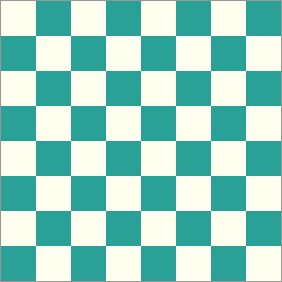

Image after Harris Corner Detector:


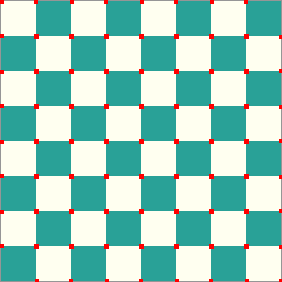

In [6]:
# use openCV to read the image and change it into a grayscale one
filename = 'image.jpg'
img = cv2.imread(filename)
print("Originl image:")
cv2_imshow(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# convert to float32
gray = np.float32(gray)
# use the function cv2.cornerHarris() to detect the corners
dst = cv2.cornerHarris(gray,2,3,0.04)
# result is dilated for marking the corners, not important 
# you can run the code again without this command and compare the result
dst = cv2.dilate(dst, None)
# once the pixel is specified as a corner(when the value is greater than threshold), 
# change it into a red dot(here we assume the threshold is equal to 0.01*dst.max())
img[dst>0.02*dst.max()]=[0,0,255]
# show the image image
print("Image after Harris Corner Detector:")
cv2_imshow(img)

###Step by step to create a Harris corner detection

Step1 : Color to grayscale

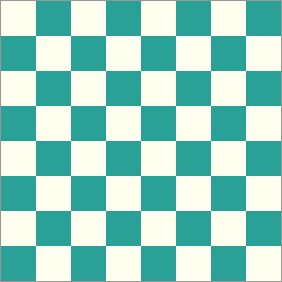

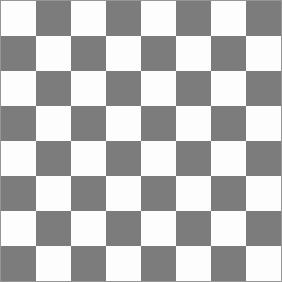

In [7]:
# use openCV to read the image and show it
img = cv2.imread(filename)
cv2_imshow(img)

# change it into a grayscale one then show it
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

Step 2: Spatial derivative calculation

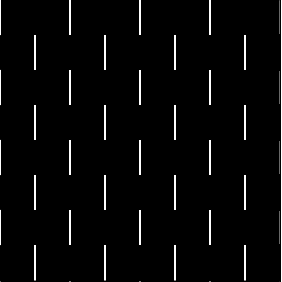

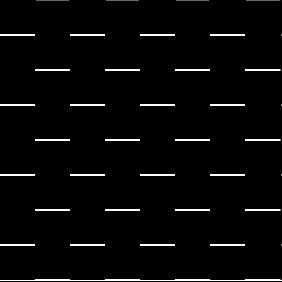

In [8]:
# Ix & Iy are image derivatives in x and y directions respectively.
# can easily calculated by using sobel kernel/?""
# the input is an array representing the image
# the return is an array representing the image derivatives  
# hint: image derivatives are the same as the calculation of the gradient in sobel detection
def gradient_x(input):
  #create a numpy zeros array whose shape should be same as the input image
  I_x = np.zeros(input.shape)

  #create a sobel x-component filter
  sobel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])

  #Pad the input image with zeros.
  input_padding = np.pad(input, 1, 'constant' ,constant_values=0)

  #Apply the Sobel filter. Avoid processing outside the boundary. 
  for row in range(int(sobel_x.shape[0]/2), input_padding.shape[0] - int(sobel_x.shape[0]/2)):
    for col in range(int(sobel_x.shape[1]/2), input_padding.shape[1] - int(sobel_x.shape[1]/2)):
      Gx = np.sum(np.array(input_padding[row-1:row+2,col-1:col+2])*np.array(sobel_x[0:3,0:3]))
      I_x[row-2,col-2]=Gx

  return I_x

def gradient_y(input):
  #create a numpy zeros array whose shape should be same as the input image
  I_y = np.zeros(input.shape)

  #create a sobel y-component filter
  sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

  #Pad the input image with zeros.
  input_padding = np.pad(input, 1, 'constant' ,constant_values=0)

  #Apply the Sobel filter. Avoid processing outside the boundary
  for row in range(int(sobel_y.shape[0]/2), input_padding.shape[0] - int(sobel_y.shape[0]/2)):
    for col in range(int(sobel_y.shape[1]/2), input_padding.shape[1] - int(sobel_y.shape[1]/2)):
      Gy = np.sum(np.array(input_padding[row-1:row+2,col-1:col+2])*np.array(sobel_y[0:3,0:3]))
      I_y[row-2,col-2]=Gy

  return I_y

# get the image derivatives in x and y directions respectively
I_x = gradient_x(gray)
I_y = gradient_y(gray)

# show the image of I_x & I_y
cv2_imshow(I_x)
cv2_imshow(I_y)

Step 3: Structure tensor setup
$$
M = g(\sigma_I)*
    \begin{bmatrix}
    I_x^2(\sigma_D) & I_xI_y(\sigma_D)\\\\
    I_xI_y(\sigma_D) & I_y^2(\sigma_D)
    \end{bmatrix}
  =  
    \begin{bmatrix}
    Ixx & Ixy\\\\
    Ixy & Iyy
    \end{bmatrix}
$$

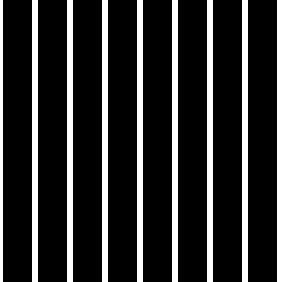

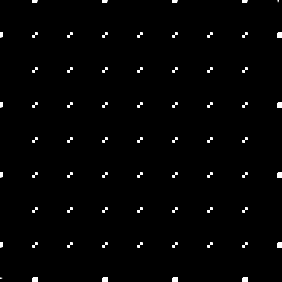

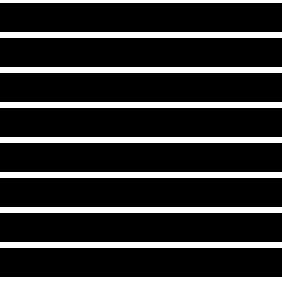

In [9]:
# Before calculating determinant M, we need to get the Ixx value by Ix*Ix and apply Gaussian filter with σ = 1 and kernel size = 5, 5
# reference: https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html
def make_5x5_gaussian_filter(sigma):
  #create 5X5 array as filter
  gaussian_filter = np.zeros([5, 5])
  #use gaussian distribution to write filter 
  for row in range(5):
    for col in range(5):
      gaussian_filter[row, col] = 1/(2*np.pi*sigma**2)*np.e**(-((col-2)**2+(row-2)**2)/(2*(sigma**2)))
  #normalization
  gaussian_filter=gaussian_filter/np.sum(gaussian_filter)
  #retrun filter
  return gaussian_filter
def gaussian_operator (input):
  # create a numpy zeros array whose shape should be same as the input image
  img_x = np.zeros(input.shape)
  # TODO: create a sobel y-component filter 
  gaussian = make_5x5_gaussian_filter(1)

  # TODO: Pad the input image with zeros. Padding width should be equal half of the filter width.
  input_padding = np.pad(input, int(gaussian.shape[0]/2), 'constant' ,constant_values=0)

  # apply the Sobel filter. Avoid processing outside the boundary
  for row in range(int(gaussian.shape[0]/2),input_padding.shape[0]-int(gaussian.shape[0]/2)):
    # TODO: set the range when processing the image in column
    for col in range(int(gaussian.shape[1]/2),input_padding.shape[1]-int(gaussian.shape[1]/2)):
      # TODO: compute the gradient in y direction of each pixel
      # hint: np.sum() can help you to sum up the elements, be care of the index 
      img_x[row-2,col-2]= np.sum(np.array(input_padding[row-2:row+3,col-2:col+3])*np.array(gaussian[0:5,0:5]))
  return img_x
#cv2_imshow(gaussian_operator (img))

Ixx = gaussian_operator (I_x*I_x)
Ixy = gaussian_operator (I_x*I_y)
Iyy = gaussian_operator (I_y*I_y)

# show the image of Ixx, Ixy & Iyy
cv2_imshow(Ixx)
cv2_imshow(Ixy)
cv2_imshow(Iyy)

Step 4: Harris response calculation
&
Step 5: Non-maximum suppression


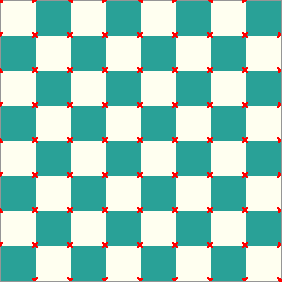

In [10]:
# determinant of M = Ixx * Iyy - Ixy ** 2
detM=Ixx* Iyy - Ixy ** 2

# traceM = Ixx + Iyy
traceM= Ixx + Iyy

# k: empirical constant, here we use 0.04
k = 0.04

# calculate R, R = detM - k * (traceM ** 2)
R=detM - k * (traceM ** 2)

# copy the image and then use it to be labeled
img_copy = np.copy(img)

# once the pixel is specified as a corner(when the value is greater than threshold), 
# change it into a red dot(here we assume the threshold is equal to 0.001*R.max())
for row in range(img_copy.shape[0]):
  for col in range(img_copy.shape[1]):
    if R[row, col] > 0.001*R.max():
      img_copy[row, col] = [0,0,255]
      
# show the image
cv2_imshow(img_copy)

## 2. Feature Space
A a good feature is characterized by: 

* Repeatability (got to be able to find it again)
* Distinctiveness/informativeness (features representing different things need to be different)
* Locality (they need to be local to the image feature and not, like, the whole image)
* Quantity (you need to be able to find enough of them for them to be properly useful)
* Accuracy (they need to accurately locate the image feature)
* Efficiency (they've got to be computable in reasonable time)

In [ ]:
!pip install opencv-python==4.5.5.64 # install latest opencv version

Downloading...
From: https://drive.google.com/uc?id=1PEg5BqSGlfMcgfqrGRzGblo4WhxXY3-Z
To: /content/1.jpg
100% 2.04M/2.04M [00:00<00:00, 175MB/s]
Downloading...
From: https://drive.google.com/uc?id=1FDE8ukopITPkQc1HQrGG4BrzHZLE1bEn
To: /content/2.jpg
100% 2.18M/2.18M [00:00<00:00, 193MB/s]


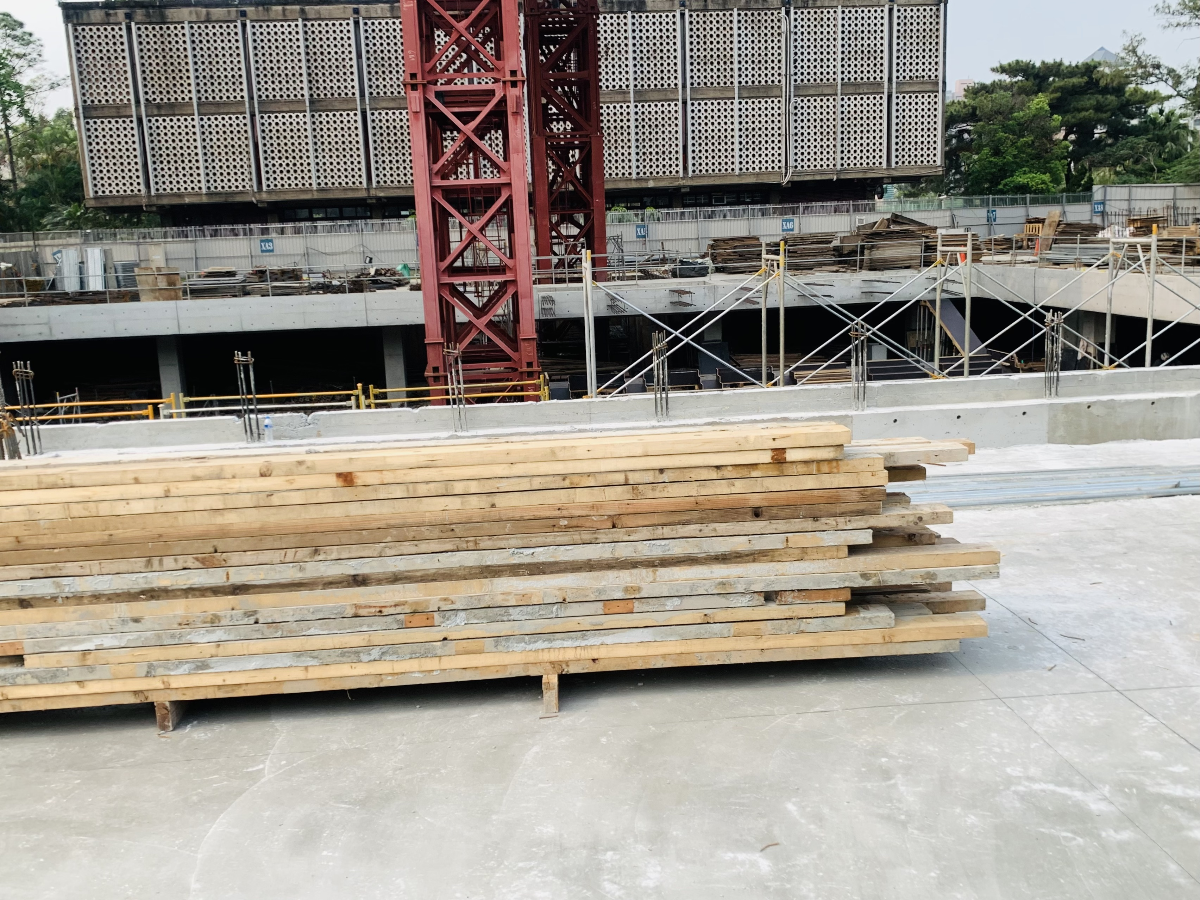

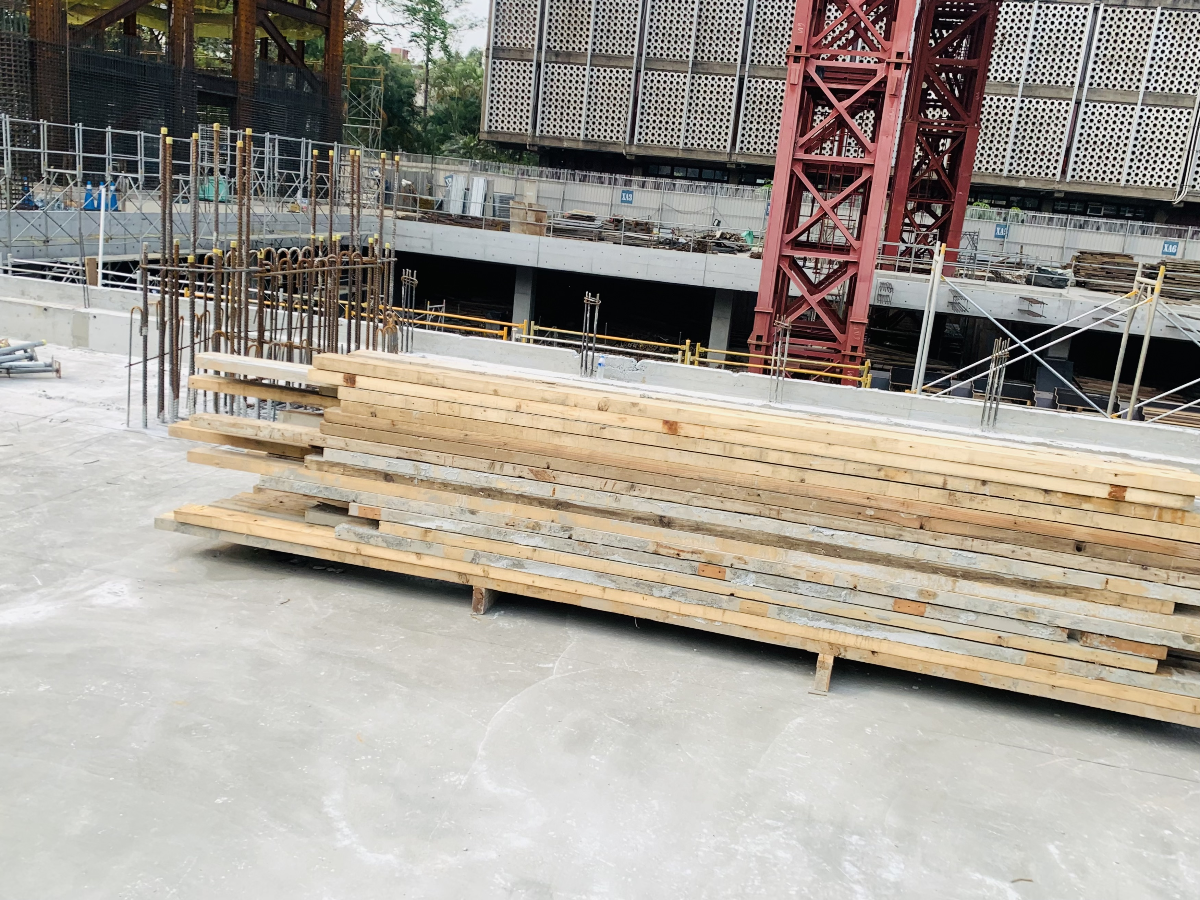

In [11]:
import numpy as np
from google.colab.patches import cv2_imshow

%matplotlib inline 
from matplotlib import pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (15, 12)

!gdown --id '1PEg5BqSGlfMcgfqrGRzGblo4WhxXY3-Z' --output 1.jpg
img1 = cv2.imread('1.jpg')
img1 = cv2.resize(img1, (1200, 900))

!gdown --id '1FDE8ukopITPkQc1HQrGG4BrzHZLE1bEn' --output 2.jpg
img2 = cv2.imread('2.jpg')
img2 = cv2.resize(img2, (1200, 900))

cv2_imshow(img1)
cv2_imshow(img2)

2-1 ORB detector

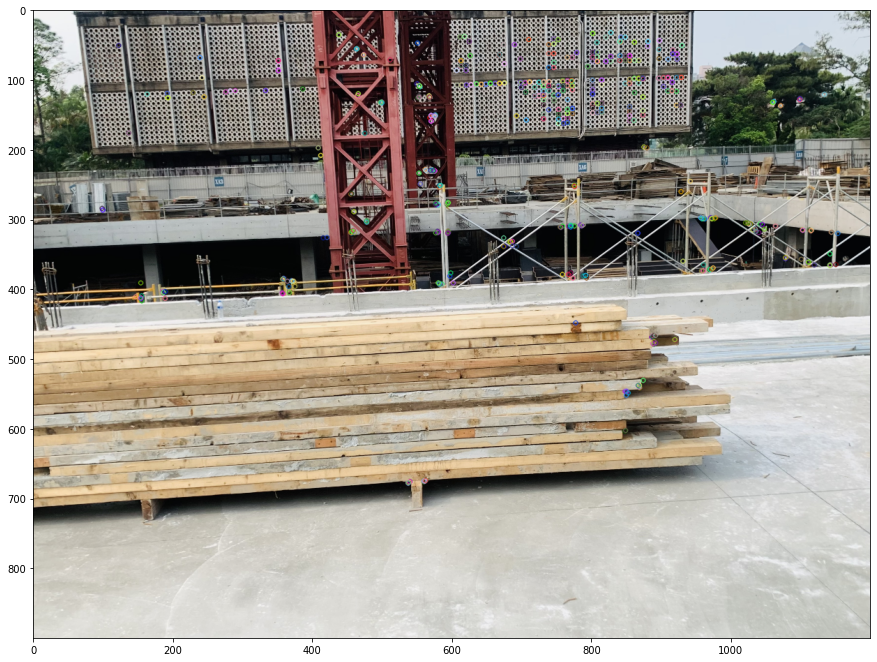

In [12]:
# copy the image 
orb_img = img1.copy()

# if you have no idea what you should do, just google it.
# https://www.google.com/search?q=orb+detector

# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints and compute the descriptors with ORB
# hint: detect() and compute() in openCV are for the purposes
kp = orb.detect(orb_img,None)


# draw keypoints by using cv2.drawKeypoints()
cv2.drawKeypoints(orb_img, kp, orb_img)

# show the image, remember to notice the color channel
plt.imshow(cv2.cvtColor(orb_img, cv2.COLOR_BGR2RGB));

2-2 SIFT detector

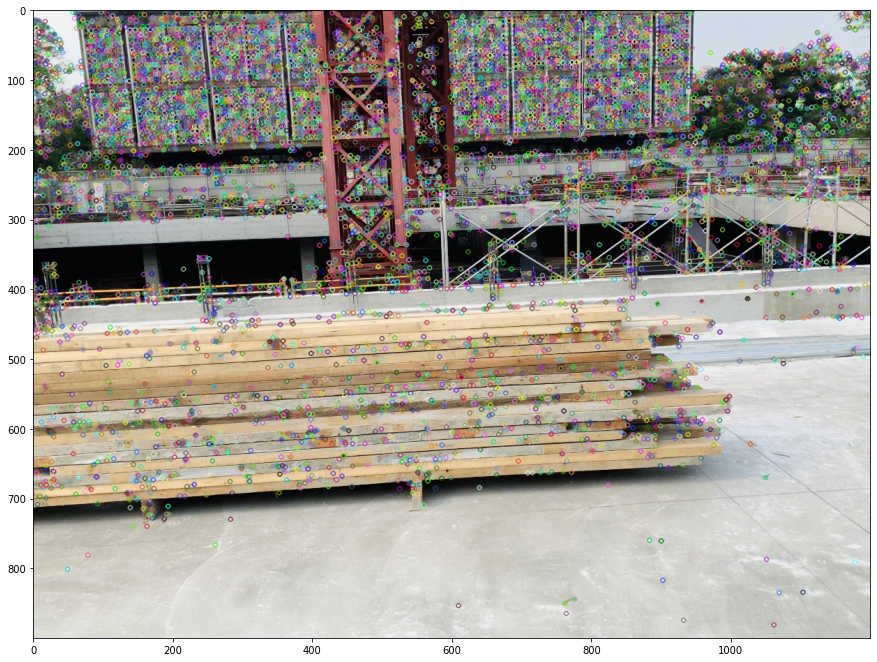

In [13]:
# copy the image 
orb_img = img1.copy()

# create sift algorithm object
sift = cv2.SIFT_create()

# find the keypoints and compute the descriptors with sift
kp = sift.detect(orb_img,None)

# draw keypoints by using cv2.drawKeypoints()
cv2.drawKeypoints(orb_img, kp, orb_img)

# show the image, remember to notice the color channel
plt.imshow(cv2.cvtColor(orb_img, cv2.COLOR_BGR2RGB));